<a href="https://colab.research.google.com/github/Natsuooo/SpeechRecognition/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import google.colab
import googleapiclient.discovery
import googleapiclient.http

google.colab.auth.authenticate_user()
drive_service = googleapiclient.discovery.build('drive', 'v3')

In [ ]:
upload_filename = 'OGVC_Vol2.zip'

file_list = drive_service.files().list(q="name='" + upload_filename + "'").execute().get('files')

# ファイル ID を取得します。
file_id = None
for file in file_list:
  if file.get('name') == upload_filename:
    file_id = file.get('id')
    break

if file_id is None:
  # ファイル ID を取得できなかった場合はエラーメッセージを出力します。
  print(upload_filename + ' が見つかりません.')
else:
  # colab 環境へファイルをアップロードします。
  with open(upload_filename, 'wb') as f:
    request = drive_service.files().get_media(fileId=file_id)
    media = googleapiclient.http.MediaIoBaseDownload(f, request)

    done = False
    while not done:
      progress_status, done = media.next_chunk()
      print(100*progress_status.progress(), end="")
      print("%完了")

  print('GoogleドライブからColab環境へのファイル取り込みが完了しました.')

25.317171954751988%完了
50.634343909503976%完了
75.95151586425595%完了
100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了しました.


In [ ]:
import zipfile

def unzip_with_pwd_ja(filename, path='.', pwd=b''):
    with zipfile.ZipFile(filename, 'r') as zip_file:
        try:
            for info in zip_file.infolist():
                info.filename = info.filename.encode('cp437').decode('cp932')
                zip_file.extract(info, path=path, pwd=pwd)
            print('extraction is successful!')
        except RuntimeError:
            print('{} is wrong password!'.format(pwd))

if __name__ == "__main__":
    unzip_with_pwd_ja(filename="OGVC_Vol2.zip", pwd=b'e6k2&fc8Nv?9')

extraction is successful!


In [ ]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')



Using TensorFlow backend.


In [ ]:
cmap = plt.get_cmap('inferno')
if not os.path.isdir(f'img_data'):
        os.mkdir(f'img_data')
plt.figure(figsize=(10,10))
genres = 'ANT,FEA,SUR,SAD, ANG,ACC, JOY, DIS'.split()
for g in genres:
    # pathlib.Path(f'{g}').mkdir(parents=True, exist_ok=True)     
    if not os.path.isdir(f'img_data/{g}'):
        os.mkdir(f'img_data/{g}')
    
    for filename in os.listdir(f'./genres/{g}'):
        if '_' in filename:
           filename = filename.split('_')[1] 
        songname = f'./genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf() #画像削除

FileNotFoundError: ignored

<Figure size 720x720 with 0 Axes>

In [ ]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
    print(header)
header += ' label'
header = header.split()

filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate mfcc1
filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate mfcc1 mfcc2
filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate mfcc1 mfcc2 mfcc3
filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate mfcc1 mfcc2 mfcc3 mfcc4
filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate mfcc1 mfcc2 mfcc3 mfcc4 mfcc5
filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate mfcc1 mfcc2 mfcc3 mfcc4 mfcc5 mfcc6
filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate mfcc1 mfcc2 mfcc3 mfcc4 mfcc5 mfcc6 mfcc7
filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate mfcc1 mfcc2 mfcc3 mfcc4 mfcc5 mfcc6 mfcc7 mfcc8
filename chroma_stft rmse spectral_centroid spectral_bandwidth r

In [ ]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

dirs='./Acted/wav/F1/A ./Acted/wav/F1/B ./Acted/wav/F2/A ./Acted/wav/F2/B ./Acted/wav/M1/A ./Acted/wav/M1/B ./Acted/wav/M2/A ./Acted/wav/M2/B'.split()
for d in dirs:
  for filename in os.listdir(f'{d}'):
    songname=f'{d}/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    rmse = librosa.feature.rmse(y=y)
    label= filename[7:10]
    #各要素の平均値を取る
    to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
    for e in mfcc:
        to_append += f' {np.mean(e)}'
    to_append += f' {label}'
    file = open('data.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())


      
           

In [ ]:
data = pd.read_csv('data.csv')
data.head(5)

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,FOY0402JOY3.wav,0.370007,0.071742,2109.171292,2405.590027,4268.447034,0.068239,-319.929866,48.220950,0.675243,14.931518,9.715407,-8.201068,-9.259436,3.906333,-5.641549,2.904349,-5.249059,4.033050,-2.367375,5.292487,2.038911,-1.878613,7.481892,12.728082,7.629287,12.724996,JOY
1,FOY1408FEA3.wav,0.435397,0.019257,2007.626597,2418.355704,4028.323975,0.075684,-519.043919,33.379053,20.574443,8.049567,0.591595,7.707225,12.491128,7.665144,2.735350,7.405596,4.066066,8.519486,5.420973,10.667707,7.176854,9.030803,10.839053,13.208842,7.716877,7.178208,FEA
2,FOY1409JOY0.wav,0.466447,0.009080,2161.865610,2365.847598,4295.874023,0.094035,-540.292955,65.975330,22.159098,18.061130,-3.594571,13.484890,14.523288,8.758739,4.139228,10.829205,0.888795,7.723224,2.553965,9.499454,0.261131,5.279184,-0.835908,5.068386,2.379533,2.645287,JOY
3,FOY0403FEA3.wav,0.448614,0.012173,2281.732135,2707.172442,5301.659557,0.075767,-443.843803,56.580750,2.561694,12.968075,12.838074,10.051015,4.563215,14.479173,13.491681,13.064488,2.601683,4.457601,0.307409,6.438884,0.112352,3.000848,0.373316,2.034553,7.872250,11.254058,FEA
4,FOY1602SAD3.wav,0.382021,0.013930,1730.760420,2135.340237,3287.631420,0.058324,-483.889952,84.432941,0.686327,15.492902,7.368459,5.857882,5.177007,-3.172914,-1.430353,4.902657,-0.413804,5.777523,-5.044719,7.042298,1.514455,-4.324051,4.487192,4.673807,3.950302,10.630242,SAD


In [ ]:
saving_filename = "data.csv"

file_metadata = {
  'name': saving_filename,
  'mimeType': 'application/octet-stream'
}
media = googleapiclient.http.MediaFileUpload(saving_filename, 
                        mimetype='application/octet-stream',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()

In [ ]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

(2656, 28)

Train on 2124 samples, validate on 532 samples
Epoch 1/200
2124/2124 [==============================] - 0s 191us/step - loss: 2.1411 - acc: 0.2128 - val_loss: 1.9615 - val_acc: 0.3083
Epoch 2/200
2124/2124 [==============================] - 0s 42us/step - loss: 1.8519 - acc: 0.3065 - val_loss: 1.8226 - val_acc: 0.3383
Epoch 3/200
2124/2124 [==============================] - 0s 41us/step - loss: 1.7115 - acc: 0.3734 - val_loss: 1.7698 - val_acc: 0.3571
Epoch 4/200
2124/2124 [==============================] - 0s 48us/step - loss: 1.6088 - acc: 0.4181 - val_loss: 1.7066 - val_acc: 0.3703
Epoch 5/200
2124/2124 [==============================] - 0s 48us/step - loss: 1.5329 - acc: 0.4421 - val_loss: 1.6528 - val_acc: 0.3891
Epoch 6/200
2124/2124 [==============================] - 0s 46us/step - loss: 1.4597 - acc: 0.4619 - val_loss: 1.6244 - val_acc: 0.4023
Epoch 7/200
2124/2124 [==============================] - 0s 43us/step - loss: 1.3953 - acc: 0.4831 - val_loss: 1.6119 - val_acc: 0.4004


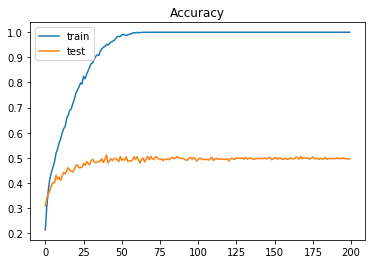

In [ ]:


from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


hist=model.fit(X_train, y_train,
               batch_size=128,
               epochs=200,
               verbose=1,
               validation_data=(X_test, y_test))

import matplotlib.pyplot as plt

score=model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 2124 samples, validate on 532 samples
Epoch 1/200
2124/2124 [==============================] - 0s 195us/step - loss: 2.2067 - acc: 0.1794 - val_loss: 2.0694 - val_acc: 0.2462
Epoch 2/200
2124/2124 [==============================] - 0s 24us/step - loss: 1.9763 - acc: 0.2947 - val_loss: 1.9218 - val_acc: 0.2857
Epoch 3/200
2124/2124 [==============================] - 0s 29us/step - loss: 1.8221 - acc: 0.3362 - val_loss: 1.8278 - val_acc: 0.3308
Epoch 4/200
2124/2124 [==============================] - 0s 29us/step - loss: 1.7225 - acc: 0.3644 - val_loss: 1.7609 - val_acc: 0.3534
Epoch 5/200
2124/2124 [==============================] - 0s 26us/step - loss: 1.6389 - acc: 0.3978 - val_loss: 1.7167 - val_acc: 0.3722
Epoch 6/200
2124/2124 [==============================] - 0s 24us/step - loss: 1.5691 - acc: 0.4223 - val_loss: 1.6813 - val_acc: 0.3816
Epoch 7/200
2124/2124 [==============================] - 0s 23us/step - loss: 1.5125 - acc: 0.4383 - val_loss: 1.6561 - val_acc: 0.3609


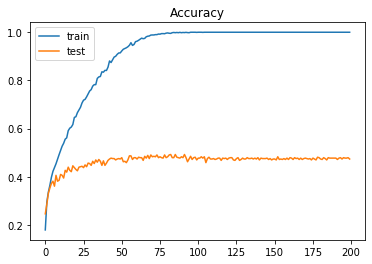

In [ ]:


from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


hist=model.fit(X_train, y_train,
               batch_size=256,
               epochs=200,
               verbose=1,
               validation_data=(X_test, y_test))

import matplotlib.pyplot as plt

score=model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 2124 samples, validate on 532 samples
Epoch 1/200
2124/2124 [==============================] - 1s 243us/step - loss: 2.0473 - acc: 0.2298 - val_loss: 1.8506 - val_acc: 0.3102
Epoch 2/200
2124/2124 [==============================] - 0s 23us/step - loss: 1.7783 - acc: 0.3390 - val_loss: 1.7498 - val_acc: 0.3590
Epoch 3/200
2124/2124 [==============================] - 0s 24us/step - loss: 1.6549 - acc: 0.3865 - val_loss: 1.6905 - val_acc: 0.3628
Epoch 4/200
2124/2124 [==============================] - 0s 25us/step - loss: 1.5985 - acc: 0.3941 - val_loss: 1.6789 - val_acc: 0.3966
Epoch 5/200
2124/2124 [==============================] - 0s 28us/step - loss: 1.5464 - acc: 0.4190 - val_loss: 1.6438 - val_acc: 0.3985
Epoch 6/200
2124/2124 [==============================] - 0s 27us/step - loss: 1.4872 - acc: 0.4590 - val_loss: 1.6142 - val_acc: 0.4060
Epoch 7/200
2124/212

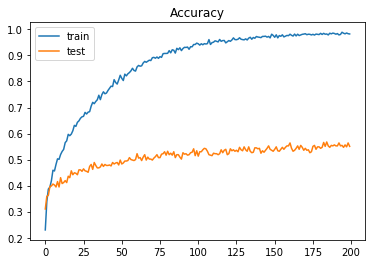

In [ ]:
from keras import models
from keras import layers
from keras.layers import Dense, Dropout

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


hist=model.fit(X_train, y_train,
               batch_size=256,
               epochs=200,
               verbose=1,
               validation_data=(X_test, y_test))

import matplotlib.pyplot as plt

score=model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 2124 samples, validate on 532 samples
Epoch 1/200
2124/2124 [==============================] - 1s 276us/step - loss: 1.9686 - acc: 0.2613 - val_loss: 1.8515 - val_acc: 0.2970
Epoch 2/200
2124/2124 [==============================] - 0s 24us/step - loss: 1.7166 - acc: 0.3493 - val_loss: 1.7641 - val_acc: 0.3346
Epoch 3/200
2124/2124 [==============================] - 0s 25us/step - loss: 1.6431 - acc: 0.3832 - val_loss: 1.7278 - val_acc: 0.3571
Epoch 4/200
2124/2124 [==============================] - 0s 26us/step - loss: 1.5686 - acc: 0.4261 - val_loss: 1.6601 - val_acc: 0.3741
Epoch 5/200
2124/2124 [==============================] - 0s 24us/step - loss: 1.5371 - acc: 0.4313 - val_loss: 1.6669 - val_acc: 0.3440
Epoch 6/200
2124/2124 [==============================] - 0s 26us/step - loss: 1.4717 - acc: 0.4567 - val_loss: 1.6466 - val_acc: 0.3816
Epoch 7/200
2124/2124 [==============================] - 0s 26us/step - loss: 1.4594 - acc: 0.4713 - val_loss: 1.6315 - val_acc: 0.3778


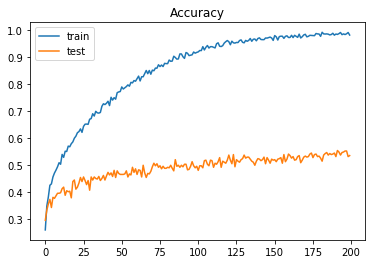

In [ ]:
from keras import models
from keras import layers
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=RMSprop(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


hist=model.fit(X_train, y_train,
               batch_size=256,
               epochs=200,
               verbose=1,
               validation_data=(X_test, y_test))

import matplotlib.pyplot as plt

score=model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 2124 samples, validate on 532 samples
Epoch 1/200
2124/2124 [==============================] - 1s 408us/step - loss: 2.2040 - acc: 0.1464 - val_loss: 2.0271 - val_acc: 0.2632
Epoch 2/200
2124/2124 [==============================] - 0s 30us/step - loss: 2.0210 - acc: 0.2316 - val_loss: 1.9155 - val_acc: 0.2914
Epoch 3/200
2124/2124 [==============================] - 0s 29us/step - loss: 1.9222 - acc: 0.2641 - val_loss: 1.8435 - val_acc: 0.3383
Epoch 4/200
2124/2124 [==============================] - 0s 29us/step - loss: 1.8595 - acc: 0.2877 - val_loss: 1.8147 - val_acc: 0.3139
Epoch 5/200
2124/2124 [==============================] - 0s 32us/step - loss: 1.7914 - acc: 0.3225 - val_loss: 1.7651 - val_acc: 0.3534
Epoch 6/200
2124/2124 [==============================] - 0s 29us/step - loss: 1.7318 - acc: 0.3460 - val_loss: 1.7424 - val_acc: 0.3571
Epoch 7/200
2124/2124 [==============================] - 0s 33us/step - loss: 1.7116 - acc: 0.3653 - val_loss: 1.7115 - val_acc: 0.3553


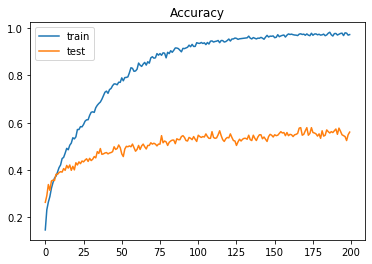

In [ ]:
from keras import models
from keras import layers
from keras.layers import Dense, Dropout

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


hist=model.fit(X_train, y_train,
               batch_size=256,
               epochs=200,
               verbose=1,
               validation_data=(X_test, y_test))

import matplotlib.pyplot as plt

score=model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 2124 samples, validate on 532 samples
Epoch 1/200
2124/2124 [==============================] - 1s 271us/step - loss: 2.2395 - acc: 0.1055 - val_loss: 2.1313 - val_acc: 0.1316
Epoch 2/200
2124/2124 [==============================] - 0s 21us/step - loss: 2.1146 - acc: 0.1441 - val_loss: 2.1071 - val_acc: 0.1316
Epoch 3/200
2124/2124 [==============================] - 0s 20us/step - loss: 2.0951 - acc: 0.1460 - val_loss: 2.0783 - val_acc: 0.1748
Epoch 4/200
2124/2124 [==============================] - 0s 20us/step - loss: 2.0823 - acc: 0.1756 - val_loss: 2.0841 - val_acc: 0.1410
Epoch 5/200
2124/2124 [==============================] - 0s 21us/step - loss: 2.0764 - acc: 0.1662 - val_loss: 2.0764 - val_acc: 0.1598
Epoch 6/200
2124/2124 [==============================] - 0s 20us/step - loss: 2.0670 - acc: 0.1813 - val_loss: 2.0528 - val_acc: 0.1805
Epoch 7/200
2124/2124 [==============================] - 0s 19us/step - loss: 2.0604 - acc: 0.1794 - val_loss: 2.0648 - val_acc: 0.1466


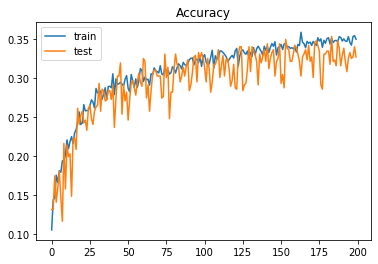

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD


model = Sequential()
model.add(Dense(512, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(Dense(256))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


hist=model.fit(X_train, y_train,
               batch_size=256,
               epochs=200,
               verbose=1,
               validation_data=(X_test, y_test))

import matplotlib.pyplot as plt

score=model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 2124 samples, validate on 532 samples
Epoch 1/400
2124/2124 [==============================] - 1s 361us/step - loss: 2.3889 - acc: 0.0942 - val_loss: 2.2698 - val_acc: 0.1504
Epoch 2/400
2124/2124 [==============================] - 0s 23us/step - loss: 2.1800 - acc: 0.1949 - val_loss: 2.1145 - val_acc: 0.2293
Epoch 3/400
2124/2124 [==============================] - 0s 25us/step - loss: 2.0388 - acc: 0.2524 - val_loss: 2.0107 - val_acc: 0.2801
Epoch 4/400
2124/2124 [==============================] - 0s 23us/step - loss: 1.9333 - acc: 0.2990 - val_loss: 1.9241 - val_acc: 0.3120
Epoch 5/400
2124/2124 [==============================] - 0s 23us/step - loss: 1.8569 - acc: 0.3192 - val_loss: 1.8688 - val_acc: 0.3421
Epoch 6/400
2124/2124 [==============================] - 0s 26us/step - loss: 1.7972 - acc: 0.3484 - val_loss: 1.8217 - val_acc: 0.3553
Epoch 7/400
2124/2124 [==============================] - 0s 22us/step - loss: 1.7473 - acc: 0.3616 - val_loss: 1.7959 - val_acc: 0.3496


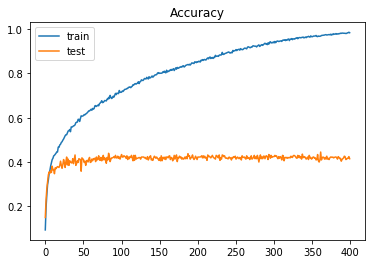

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD


model = Sequential()
model.add(Dense(64,  input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer='adadelta',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


hist=model.fit(X_train, y_train,
               batch_size=256,
               epochs=400,
               verbose=1,
               validation_data=(X_test, y_test))

import matplotlib.pyplot as plt

score=model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 2124 samples, validate on 532 samples
Epoch 1/200
2124/2124 [==============================] - 1s 640us/step - loss: 2.0756 - acc: 0.2340 - val_loss: 1.8808 - val_acc: 0.3327
Epoch 2/200
2124/2124 [==============================] - 0s 27us/step - loss: 1.8051 - acc: 0.3371 - val_loss: 1.8320 - val_acc: 0.2951
Epoch 3/200
2124/2124 [==============================] - 0s 25us/step - loss: 1.7060 - acc: 0.3710 - val_loss: 1.8204 - val_acc: 0.2989
Epoch 4/200
2124/2124 [==============================] - 0s 28us/step - loss: 1.6274 - acc: 0.4058 - val_loss: 1.7351 - val_acc: 0.3628
Epoch 5/200
2124/2124 [==============================] - 0s 29us/step - loss: 1.5733 - acc: 0.4171 - val_loss: 1.7289 - val_acc: 0.3722
Epoch 6/200
2124/2124 [==============================] - 0s 27us/step - loss: 1.5317 - acc: 0.4341 - val_loss: 1.7621 - val_acc: 0.3289
Epoch 7/200
2124/2124 [==============================] - 0s 26us/step - loss: 1.4845 - acc: 0.4567 - val_loss: 1.7134 - val_acc: 0.3440


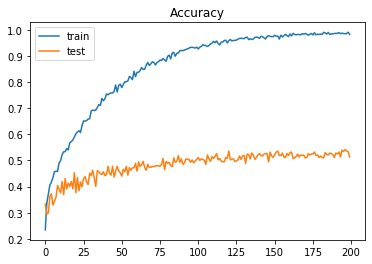

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD


model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.15))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adadelta',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


hist=model.fit(X_train, y_train,
               batch_size=256,
               epochs=200,
               verbose=1,
               validation_data=(X_test, y_test))

import matplotlib.pyplot as plt

score=model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()